In [2]:
%matplotlib inline

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer

In [3]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


Visualizing an image data set sample

[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


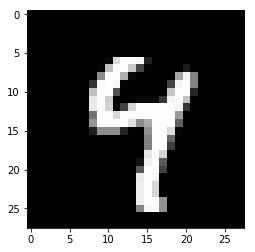

In [4]:
img = mnist.train.images[2]
label = mnist.train.labels[2]
plt.imshow(img.reshape((28, 28)), cmap='Greys_r')
print(label)


Defining the network 

In [5]:
def conv_net(inputs):
    conv = tf.layers.conv2d(inputs, 32, (5,5), padding='same', activation=tf.nn.relu)
    
    conv = tf.layers.max_pooling2d(conv,(2,2), (2,2), padding='same')

    conv = tf.layers.conv2d(conv, 64, (5,5), padding='same', activation=tf.nn.relu)

    conv = tf.layers.max_pooling2d(conv,(2,2), (2,2), padding='same')
        
    conv = tf.contrib.layers.flatten(conv)
    
    conv = tf.contrib.layers.fully_connected(conv, 1024, activation_fn=tf.nn.relu)
        
    conv = tf.contrib.layers.fully_connected(conv, 10, activation_fn=None)

    return conv

In [6]:
x = tf.placeholder(dtype=tf.float32, shape=[None, 28, 28, 1], name='x')
y = tf.stop_gradient(tf.placeholder(dtype=tf.float32, shape=[None, 10], name='y'))

logits = conv_net(x)

logits = tf.identity(logits, name='logits')

predictions = tf.nn.softmax(logits, name='predictions')

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=y))
optimizer = tf.train.AdamOptimizer(learning_rate=0.00001).minimize(cost)

correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

Network training hyper parameters

In [7]:
epochs = 70
batch_size = 512

Training network

In [8]:
#Training helper functions    

def train_neural_network(session, optimizer, feature_batch, label_batch):
    session.run(optimizer, feed_dict={
        x: feature_batch,
        y: label_batch
    })
    
def print_training_stats(session, epoch, batch_i, feature_batch, label_batch, validation_feature, validation_label, cost, accuracy):
    loss = sess.run(cost, feed_dict={
                x: feature_batch,
                y: label_batch })
    validation_accuracy = sess.run(accuracy, feed_dict={
                x: validation_feature,
                y: validation_label })
    print('Epoch {:>2}, MNIST Batch {}: Loss: {:>10.4f} Validation Accuracy: {:.6f}'.format(epoch + 1, batch_i, loss, validation_accuracy))
    

In [11]:
save_model_path = './numbers_network_model'

print('Training...')
with tf.Session() as sess:
    # Initializing the variables]
    sess.run(tf.global_variables_initializer())
    
    # Training cycle
    for epoch in range(epochs):
        # Loop over all batches
        for i in range(mnist.train.num_examples//batch_size):
            batch = mnist.train.next_batch(batch_size)
            batch_features = batch[0].reshape((-1, 28, 28, 1))
            batch_labels = batch[1]
            train_neural_network(sess, optimizer, batch_features, batch_labels)
            
            print_training_stats(sess, epoch, i, 
                                 batch_features, batch_labels, 
                                 mnist.validation.images.reshape((-1, 28, 28, 1)), mnist.validation.labels,
                                 cost, accuracy)
            
    # Save Model
    saver = tf.train.Saver()
    save_path = saver.save(sess, save_model_path)
    sess.close()

Training...
Epoch  1, MNIST Batch 0: Loss:     2.2944 Validation Accuracy: 0.111800
Epoch  1, MNIST Batch 1: Loss:     2.2878 Validation Accuracy: 0.127000
Epoch  1, MNIST Batch 2: Loss:     2.2857 Validation Accuracy: 0.139800
Epoch  1, MNIST Batch 3: Loss:     2.2842 Validation Accuracy: 0.153800
Epoch  1, MNIST Batch 4: Loss:     2.2873 Validation Accuracy: 0.167200
Epoch  1, MNIST Batch 5: Loss:     2.2804 Validation Accuracy: 0.181800
Epoch  1, MNIST Batch 6: Loss:     2.2785 Validation Accuracy: 0.194000
Epoch  1, MNIST Batch 7: Loss:     2.2727 Validation Accuracy: 0.209200
Epoch  1, MNIST Batch 8: Loss:     2.2775 Validation Accuracy: 0.218000
Epoch  1, MNIST Batch 9: Loss:     2.2679 Validation Accuracy: 0.231200
Epoch  1, MNIST Batch 10: Loss:     2.2631 Validation Accuracy: 0.241400
Epoch  1, MNIST Batch 11: Loss:     2.2616 Validation Accuracy: 0.253000
Epoch  1, MNIST Batch 12: Loss:     2.2593 Validation Accuracy: 0.265000
Epoch  1, MNIST Batch 13: Loss:     2.2585 Valida

Epoch  2, MNIST Batch 7: Loss:     1.8313 Validation Accuracy: 0.734400
Epoch  2, MNIST Batch 8: Loss:     1.8301 Validation Accuracy: 0.736000
Epoch  2, MNIST Batch 9: Loss:     1.8244 Validation Accuracy: 0.739600
Epoch  2, MNIST Batch 10: Loss:     1.8273 Validation Accuracy: 0.741800
Epoch  2, MNIST Batch 11: Loss:     1.8202 Validation Accuracy: 0.745800
Epoch  2, MNIST Batch 12: Loss:     1.7940 Validation Accuracy: 0.746200
Epoch  2, MNIST Batch 13: Loss:     1.8042 Validation Accuracy: 0.747800
Epoch  2, MNIST Batch 14: Loss:     1.8061 Validation Accuracy: 0.746600
Epoch  2, MNIST Batch 15: Loss:     1.7818 Validation Accuracy: 0.746800
Epoch  2, MNIST Batch 16: Loss:     1.7886 Validation Accuracy: 0.745400
Epoch  2, MNIST Batch 17: Loss:     1.7665 Validation Accuracy: 0.745800
Epoch  2, MNIST Batch 18: Loss:     1.7857 Validation Accuracy: 0.745200
Epoch  2, MNIST Batch 19: Loss:     1.7741 Validation Accuracy: 0.745400
Epoch  2, MNIST Batch 20: Loss:     1.7613 Validation 

Epoch  3, MNIST Batch 14: Loss:     1.1309 Validation Accuracy: 0.797200
Epoch  3, MNIST Batch 15: Loss:     1.1587 Validation Accuracy: 0.797200
Epoch  3, MNIST Batch 16: Loss:     1.1132 Validation Accuracy: 0.798000
Epoch  3, MNIST Batch 17: Loss:     1.1215 Validation Accuracy: 0.798200
Epoch  3, MNIST Batch 18: Loss:     1.0955 Validation Accuracy: 0.799600
Epoch  3, MNIST Batch 19: Loss:     1.1171 Validation Accuracy: 0.800600
Epoch  3, MNIST Batch 20: Loss:     1.1023 Validation Accuracy: 0.800800
Epoch  3, MNIST Batch 21: Loss:     1.0983 Validation Accuracy: 0.802400
Epoch  3, MNIST Batch 22: Loss:     1.1100 Validation Accuracy: 0.803200
Epoch  3, MNIST Batch 23: Loss:     1.1200 Validation Accuracy: 0.804400
Epoch  3, MNIST Batch 24: Loss:     1.0568 Validation Accuracy: 0.805800
Epoch  3, MNIST Batch 25: Loss:     1.0940 Validation Accuracy: 0.807200
Epoch  3, MNIST Batch 26: Loss:     1.0529 Validation Accuracy: 0.807000
Epoch  3, MNIST Batch 27: Loss:     1.0445 Validati

Epoch  4, MNIST Batch 20: Loss:     0.6929 Validation Accuracy: 0.848400
Epoch  4, MNIST Batch 21: Loss:     0.7136 Validation Accuracy: 0.849200
Epoch  4, MNIST Batch 22: Loss:     0.6968 Validation Accuracy: 0.850400
Epoch  4, MNIST Batch 23: Loss:     0.7151 Validation Accuracy: 0.850200
Epoch  4, MNIST Batch 24: Loss:     0.7167 Validation Accuracy: 0.851400
Epoch  4, MNIST Batch 25: Loss:     0.7314 Validation Accuracy: 0.852600
Epoch  4, MNIST Batch 26: Loss:     0.6784 Validation Accuracy: 0.853400
Epoch  4, MNIST Batch 27: Loss:     0.6673 Validation Accuracy: 0.854000
Epoch  4, MNIST Batch 28: Loss:     0.6732 Validation Accuracy: 0.854200
Epoch  4, MNIST Batch 29: Loss:     0.6851 Validation Accuracy: 0.854800
Epoch  4, MNIST Batch 30: Loss:     0.6983 Validation Accuracy: 0.855200
Epoch  4, MNIST Batch 31: Loss:     0.6934 Validation Accuracy: 0.855400
Epoch  4, MNIST Batch 32: Loss:     0.6490 Validation Accuracy: 0.853800
Epoch  4, MNIST Batch 33: Loss:     0.6779 Validati

Epoch  5, MNIST Batch 27: Loss:     0.5266 Validation Accuracy: 0.881000
Epoch  5, MNIST Batch 28: Loss:     0.5151 Validation Accuracy: 0.881200
Epoch  5, MNIST Batch 29: Loss:     0.5286 Validation Accuracy: 0.881800
Epoch  5, MNIST Batch 30: Loss:     0.5937 Validation Accuracy: 0.882000
Epoch  5, MNIST Batch 31: Loss:     0.5215 Validation Accuracy: 0.881000
Epoch  5, MNIST Batch 32: Loss:     0.5002 Validation Accuracy: 0.881200
Epoch  5, MNIST Batch 33: Loss:     0.5148 Validation Accuracy: 0.881800
Epoch  5, MNIST Batch 34: Loss:     0.5098 Validation Accuracy: 0.881600
Epoch  5, MNIST Batch 35: Loss:     0.5026 Validation Accuracy: 0.881400
Epoch  5, MNIST Batch 36: Loss:     0.5048 Validation Accuracy: 0.881800
Epoch  5, MNIST Batch 37: Loss:     0.5585 Validation Accuracy: 0.881800
Epoch  5, MNIST Batch 38: Loss:     0.5064 Validation Accuracy: 0.883200
Epoch  5, MNIST Batch 39: Loss:     0.5004 Validation Accuracy: 0.882800
Epoch  5, MNIST Batch 40: Loss:     0.5368 Validati

Epoch  6, MNIST Batch 33: Loss:     0.4397 Validation Accuracy: 0.898600
Epoch  6, MNIST Batch 34: Loss:     0.3963 Validation Accuracy: 0.898600
Epoch  6, MNIST Batch 35: Loss:     0.4482 Validation Accuracy: 0.899400
Epoch  6, MNIST Batch 36: Loss:     0.4027 Validation Accuracy: 0.899400
Epoch  6, MNIST Batch 37: Loss:     0.4426 Validation Accuracy: 0.900600
Epoch  6, MNIST Batch 38: Loss:     0.4141 Validation Accuracy: 0.901000
Epoch  6, MNIST Batch 39: Loss:     0.4404 Validation Accuracy: 0.901000
Epoch  6, MNIST Batch 40: Loss:     0.4001 Validation Accuracy: 0.900400
Epoch  6, MNIST Batch 41: Loss:     0.4095 Validation Accuracy: 0.900800
Epoch  6, MNIST Batch 42: Loss:     0.3809 Validation Accuracy: 0.901000
Epoch  6, MNIST Batch 43: Loss:     0.4034 Validation Accuracy: 0.901000
Epoch  6, MNIST Batch 44: Loss:     0.4278 Validation Accuracy: 0.900400
Epoch  6, MNIST Batch 45: Loss:     0.3599 Validation Accuracy: 0.900000
Epoch  6, MNIST Batch 46: Loss:     0.4017 Validati

Epoch  7, MNIST Batch 39: Loss:     0.3861 Validation Accuracy: 0.911000
Epoch  7, MNIST Batch 40: Loss:     0.3061 Validation Accuracy: 0.912000
Epoch  7, MNIST Batch 41: Loss:     0.3557 Validation Accuracy: 0.912200
Epoch  7, MNIST Batch 42: Loss:     0.4087 Validation Accuracy: 0.911800
Epoch  7, MNIST Batch 43: Loss:     0.3688 Validation Accuracy: 0.911600
Epoch  7, MNIST Batch 44: Loss:     0.3634 Validation Accuracy: 0.912000
Epoch  7, MNIST Batch 45: Loss:     0.3474 Validation Accuracy: 0.911000
Epoch  7, MNIST Batch 46: Loss:     0.3639 Validation Accuracy: 0.911200
Epoch  7, MNIST Batch 47: Loss:     0.3634 Validation Accuracy: 0.911200
Epoch  7, MNIST Batch 48: Loss:     0.3315 Validation Accuracy: 0.911600
Epoch  7, MNIST Batch 49: Loss:     0.3623 Validation Accuracy: 0.911600
Epoch  7, MNIST Batch 50: Loss:     0.3123 Validation Accuracy: 0.911600
Epoch  7, MNIST Batch 51: Loss:     0.3830 Validation Accuracy: 0.912200
Epoch  7, MNIST Batch 52: Loss:     0.3312 Validati

Epoch  8, MNIST Batch 46: Loss:     0.3197 Validation Accuracy: 0.921400
Epoch  8, MNIST Batch 47: Loss:     0.3166 Validation Accuracy: 0.921000
Epoch  8, MNIST Batch 48: Loss:     0.2905 Validation Accuracy: 0.921000
Epoch  8, MNIST Batch 49: Loss:     0.3561 Validation Accuracy: 0.921400
Epoch  8, MNIST Batch 50: Loss:     0.3784 Validation Accuracy: 0.920800
Epoch  8, MNIST Batch 51: Loss:     0.2908 Validation Accuracy: 0.921400
Epoch  8, MNIST Batch 52: Loss:     0.2960 Validation Accuracy: 0.921000
Epoch  8, MNIST Batch 53: Loss:     0.3190 Validation Accuracy: 0.921200
Epoch  8, MNIST Batch 54: Loss:     0.3494 Validation Accuracy: 0.921600
Epoch  8, MNIST Batch 55: Loss:     0.3247 Validation Accuracy: 0.921600
Epoch  8, MNIST Batch 56: Loss:     0.3633 Validation Accuracy: 0.921400
Epoch  8, MNIST Batch 57: Loss:     0.3374 Validation Accuracy: 0.923000
Epoch  8, MNIST Batch 58: Loss:     0.3023 Validation Accuracy: 0.922800
Epoch  8, MNIST Batch 59: Loss:     0.3015 Validati

Epoch  9, MNIST Batch 52: Loss:     0.2699 Validation Accuracy: 0.927600
Epoch  9, MNIST Batch 53: Loss:     0.2953 Validation Accuracy: 0.927400
Epoch  9, MNIST Batch 54: Loss:     0.3035 Validation Accuracy: 0.927800
Epoch  9, MNIST Batch 55: Loss:     0.2971 Validation Accuracy: 0.927400
Epoch  9, MNIST Batch 56: Loss:     0.3080 Validation Accuracy: 0.927400
Epoch  9, MNIST Batch 57: Loss:     0.2948 Validation Accuracy: 0.927200
Epoch  9, MNIST Batch 58: Loss:     0.2697 Validation Accuracy: 0.927400
Epoch  9, MNIST Batch 59: Loss:     0.3153 Validation Accuracy: 0.926800
Epoch  9, MNIST Batch 60: Loss:     0.2453 Validation Accuracy: 0.927600
Epoch  9, MNIST Batch 61: Loss:     0.2757 Validation Accuracy: 0.928400
Epoch  9, MNIST Batch 62: Loss:     0.2723 Validation Accuracy: 0.928600
Epoch  9, MNIST Batch 63: Loss:     0.3691 Validation Accuracy: 0.929400
Epoch  9, MNIST Batch 64: Loss:     0.2815 Validation Accuracy: 0.929400
Epoch  9, MNIST Batch 65: Loss:     0.2918 Validati

Epoch 10, MNIST Batch 59: Loss:     0.2442 Validation Accuracy: 0.933600
Epoch 10, MNIST Batch 60: Loss:     0.2744 Validation Accuracy: 0.934000
Epoch 10, MNIST Batch 61: Loss:     0.2269 Validation Accuracy: 0.934000
Epoch 10, MNIST Batch 62: Loss:     0.2852 Validation Accuracy: 0.933800
Epoch 10, MNIST Batch 63: Loss:     0.2218 Validation Accuracy: 0.933200
Epoch 10, MNIST Batch 64: Loss:     0.2913 Validation Accuracy: 0.934200
Epoch 10, MNIST Batch 65: Loss:     0.2914 Validation Accuracy: 0.933200
Epoch 10, MNIST Batch 66: Loss:     0.2827 Validation Accuracy: 0.933400
Epoch 10, MNIST Batch 67: Loss:     0.2972 Validation Accuracy: 0.932600
Epoch 10, MNIST Batch 68: Loss:     0.2761 Validation Accuracy: 0.930800
Epoch 10, MNIST Batch 69: Loss:     0.2207 Validation Accuracy: 0.930200
Epoch 10, MNIST Batch 70: Loss:     0.2440 Validation Accuracy: 0.931200
Epoch 10, MNIST Batch 71: Loss:     0.2556 Validation Accuracy: 0.930800
Epoch 10, MNIST Batch 72: Loss:     0.2585 Validati

Epoch 11, MNIST Batch 65: Loss:     0.2256 Validation Accuracy: 0.938400
Epoch 11, MNIST Batch 66: Loss:     0.2504 Validation Accuracy: 0.938400
Epoch 11, MNIST Batch 67: Loss:     0.2339 Validation Accuracy: 0.938800
Epoch 11, MNIST Batch 68: Loss:     0.2114 Validation Accuracy: 0.939200
Epoch 11, MNIST Batch 69: Loss:     0.1991 Validation Accuracy: 0.939000
Epoch 11, MNIST Batch 70: Loss:     0.2511 Validation Accuracy: 0.939000
Epoch 11, MNIST Batch 71: Loss:     0.2894 Validation Accuracy: 0.938600
Epoch 11, MNIST Batch 72: Loss:     0.2573 Validation Accuracy: 0.938400
Epoch 11, MNIST Batch 73: Loss:     0.2944 Validation Accuracy: 0.938000
Epoch 11, MNIST Batch 74: Loss:     0.2466 Validation Accuracy: 0.938200
Epoch 11, MNIST Batch 75: Loss:     0.2246 Validation Accuracy: 0.938200
Epoch 11, MNIST Batch 76: Loss:     0.2776 Validation Accuracy: 0.938200
Epoch 11, MNIST Batch 77: Loss:     0.2842 Validation Accuracy: 0.938800
Epoch 11, MNIST Batch 78: Loss:     0.2383 Validati

Epoch 12, MNIST Batch 72: Loss:     0.2669 Validation Accuracy: 0.940600
Epoch 12, MNIST Batch 73: Loss:     0.2117 Validation Accuracy: 0.940600
Epoch 12, MNIST Batch 74: Loss:     0.2516 Validation Accuracy: 0.940000
Epoch 12, MNIST Batch 75: Loss:     0.2261 Validation Accuracy: 0.940800
Epoch 12, MNIST Batch 76: Loss:     0.1954 Validation Accuracy: 0.940400
Epoch 12, MNIST Batch 77: Loss:     0.2574 Validation Accuracy: 0.940800
Epoch 12, MNIST Batch 78: Loss:     0.2497 Validation Accuracy: 0.941200
Epoch 12, MNIST Batch 79: Loss:     0.2620 Validation Accuracy: 0.941400
Epoch 12, MNIST Batch 80: Loss:     0.2360 Validation Accuracy: 0.943000
Epoch 12, MNIST Batch 81: Loss:     0.1959 Validation Accuracy: 0.943000
Epoch 12, MNIST Batch 82: Loss:     0.2473 Validation Accuracy: 0.942800
Epoch 12, MNIST Batch 83: Loss:     0.2165 Validation Accuracy: 0.943000
Epoch 12, MNIST Batch 84: Loss:     0.2031 Validation Accuracy: 0.943400
Epoch 12, MNIST Batch 85: Loss:     0.1838 Validati

Epoch 13, MNIST Batch 78: Loss:     0.2429 Validation Accuracy: 0.944600
Epoch 13, MNIST Batch 79: Loss:     0.2208 Validation Accuracy: 0.944400
Epoch 13, MNIST Batch 80: Loss:     0.2045 Validation Accuracy: 0.944600
Epoch 13, MNIST Batch 81: Loss:     0.1825 Validation Accuracy: 0.945000
Epoch 13, MNIST Batch 82: Loss:     0.1902 Validation Accuracy: 0.945000
Epoch 13, MNIST Batch 83: Loss:     0.1968 Validation Accuracy: 0.944800
Epoch 13, MNIST Batch 84: Loss:     0.1992 Validation Accuracy: 0.944800
Epoch 13, MNIST Batch 85: Loss:     0.2089 Validation Accuracy: 0.944800
Epoch 13, MNIST Batch 86: Loss:     0.2221 Validation Accuracy: 0.945000
Epoch 13, MNIST Batch 87: Loss:     0.2154 Validation Accuracy: 0.945400
Epoch 13, MNIST Batch 88: Loss:     0.2189 Validation Accuracy: 0.945400
Epoch 13, MNIST Batch 89: Loss:     0.2355 Validation Accuracy: 0.946600
Epoch 13, MNIST Batch 90: Loss:     0.2411 Validation Accuracy: 0.946200
Epoch 13, MNIST Batch 91: Loss:     0.2281 Validati

Epoch 14, MNIST Batch 84: Loss:     0.1790 Validation Accuracy: 0.948400
Epoch 14, MNIST Batch 85: Loss:     0.1910 Validation Accuracy: 0.948600
Epoch 14, MNIST Batch 86: Loss:     0.2104 Validation Accuracy: 0.948600
Epoch 14, MNIST Batch 87: Loss:     0.1617 Validation Accuracy: 0.947800
Epoch 14, MNIST Batch 88: Loss:     0.1877 Validation Accuracy: 0.948200
Epoch 14, MNIST Batch 89: Loss:     0.2194 Validation Accuracy: 0.948000
Epoch 14, MNIST Batch 90: Loss:     0.2164 Validation Accuracy: 0.947600
Epoch 14, MNIST Batch 91: Loss:     0.2335 Validation Accuracy: 0.948600
Epoch 14, MNIST Batch 92: Loss:     0.2172 Validation Accuracy: 0.948200
Epoch 14, MNIST Batch 93: Loss:     0.1736 Validation Accuracy: 0.948200
Epoch 14, MNIST Batch 94: Loss:     0.1880 Validation Accuracy: 0.948200
Epoch 14, MNIST Batch 95: Loss:     0.2047 Validation Accuracy: 0.947600
Epoch 14, MNIST Batch 96: Loss:     0.2092 Validation Accuracy: 0.947400
Epoch 14, MNIST Batch 97: Loss:     0.2247 Validati

Epoch 15, MNIST Batch 91: Loss:     0.1689 Validation Accuracy: 0.950200
Epoch 15, MNIST Batch 92: Loss:     0.2258 Validation Accuracy: 0.949800
Epoch 15, MNIST Batch 93: Loss:     0.2391 Validation Accuracy: 0.949400
Epoch 15, MNIST Batch 94: Loss:     0.1798 Validation Accuracy: 0.949200
Epoch 15, MNIST Batch 95: Loss:     0.1557 Validation Accuracy: 0.948800
Epoch 15, MNIST Batch 96: Loss:     0.1734 Validation Accuracy: 0.948200
Epoch 15, MNIST Batch 97: Loss:     0.1671 Validation Accuracy: 0.948800
Epoch 15, MNIST Batch 98: Loss:     0.1761 Validation Accuracy: 0.948600
Epoch 15, MNIST Batch 99: Loss:     0.2594 Validation Accuracy: 0.948800
Epoch 15, MNIST Batch 100: Loss:     0.2114 Validation Accuracy: 0.948400
Epoch 15, MNIST Batch 101: Loss:     0.2116 Validation Accuracy: 0.949200
Epoch 15, MNIST Batch 102: Loss:     0.1654 Validation Accuracy: 0.950000
Epoch 15, MNIST Batch 103: Loss:     0.2192 Validation Accuracy: 0.951000
Epoch 15, MNIST Batch 104: Loss:     0.2104 Val

Epoch 16, MNIST Batch 97: Loss:     0.1615 Validation Accuracy: 0.952400
Epoch 16, MNIST Batch 98: Loss:     0.2003 Validation Accuracy: 0.952800
Epoch 16, MNIST Batch 99: Loss:     0.2086 Validation Accuracy: 0.952400
Epoch 16, MNIST Batch 100: Loss:     0.2096 Validation Accuracy: 0.952000
Epoch 16, MNIST Batch 101: Loss:     0.1834 Validation Accuracy: 0.951200
Epoch 16, MNIST Batch 102: Loss:     0.1953 Validation Accuracy: 0.951200
Epoch 16, MNIST Batch 103: Loss:     0.1486 Validation Accuracy: 0.950800
Epoch 16, MNIST Batch 104: Loss:     0.1753 Validation Accuracy: 0.951000
Epoch 16, MNIST Batch 105: Loss:     0.1685 Validation Accuracy: 0.951400
Epoch 16, MNIST Batch 106: Loss:     0.2164 Validation Accuracy: 0.951600
Epoch 17, MNIST Batch 0: Loss:     0.2086 Validation Accuracy: 0.952000
Epoch 17, MNIST Batch 1: Loss:     0.1553 Validation Accuracy: 0.951600
Epoch 17, MNIST Batch 2: Loss:     0.2116 Validation Accuracy: 0.951800
Epoch 17, MNIST Batch 3: Loss:     0.2118 Valid

Epoch 17, MNIST Batch 104: Loss:     0.1338 Validation Accuracy: 0.953400
Epoch 17, MNIST Batch 105: Loss:     0.1933 Validation Accuracy: 0.953200
Epoch 17, MNIST Batch 106: Loss:     0.2000 Validation Accuracy: 0.953200
Epoch 18, MNIST Batch 0: Loss:     0.1663 Validation Accuracy: 0.953000
Epoch 18, MNIST Batch 1: Loss:     0.2103 Validation Accuracy: 0.953800
Epoch 18, MNIST Batch 2: Loss:     0.1246 Validation Accuracy: 0.953800
Epoch 18, MNIST Batch 3: Loss:     0.2006 Validation Accuracy: 0.954200
Epoch 18, MNIST Batch 4: Loss:     0.1874 Validation Accuracy: 0.954200
Epoch 18, MNIST Batch 5: Loss:     0.2046 Validation Accuracy: 0.954800
Epoch 18, MNIST Batch 6: Loss:     0.1754 Validation Accuracy: 0.954600
Epoch 18, MNIST Batch 7: Loss:     0.1923 Validation Accuracy: 0.954600
Epoch 18, MNIST Batch 8: Loss:     0.1697 Validation Accuracy: 0.954400
Epoch 18, MNIST Batch 9: Loss:     0.2149 Validation Accuracy: 0.954600
Epoch 18, MNIST Batch 10: Loss:     0.1561 Validation Accu

Epoch 19, MNIST Batch 4: Loss:     0.1634 Validation Accuracy: 0.955800
Epoch 19, MNIST Batch 5: Loss:     0.1795 Validation Accuracy: 0.955800
Epoch 19, MNIST Batch 6: Loss:     0.1285 Validation Accuracy: 0.955800
Epoch 19, MNIST Batch 7: Loss:     0.1353 Validation Accuracy: 0.955800
Epoch 19, MNIST Batch 8: Loss:     0.1439 Validation Accuracy: 0.955600
Epoch 19, MNIST Batch 9: Loss:     0.1678 Validation Accuracy: 0.955600
Epoch 19, MNIST Batch 10: Loss:     0.1865 Validation Accuracy: 0.955800
Epoch 19, MNIST Batch 11: Loss:     0.1667 Validation Accuracy: 0.955800
Epoch 19, MNIST Batch 12: Loss:     0.1755 Validation Accuracy: 0.956000
Epoch 19, MNIST Batch 13: Loss:     0.1731 Validation Accuracy: 0.956600
Epoch 19, MNIST Batch 14: Loss:     0.1897 Validation Accuracy: 0.956600
Epoch 19, MNIST Batch 15: Loss:     0.1550 Validation Accuracy: 0.956200
Epoch 19, MNIST Batch 16: Loss:     0.1663 Validation Accuracy: 0.956200
Epoch 19, MNIST Batch 17: Loss:     0.1564 Validation Acc

Epoch 20, MNIST Batch 11: Loss:     0.1582 Validation Accuracy: 0.957800
Epoch 20, MNIST Batch 12: Loss:     0.1684 Validation Accuracy: 0.957200
Epoch 20, MNIST Batch 13: Loss:     0.1443 Validation Accuracy: 0.957800
Epoch 20, MNIST Batch 14: Loss:     0.1484 Validation Accuracy: 0.957800
Epoch 20, MNIST Batch 15: Loss:     0.1295 Validation Accuracy: 0.957000
Epoch 20, MNIST Batch 16: Loss:     0.1500 Validation Accuracy: 0.957000
Epoch 20, MNIST Batch 17: Loss:     0.1608 Validation Accuracy: 0.957200
Epoch 20, MNIST Batch 18: Loss:     0.1613 Validation Accuracy: 0.957000
Epoch 20, MNIST Batch 19: Loss:     0.2007 Validation Accuracy: 0.957000
Epoch 20, MNIST Batch 20: Loss:     0.1673 Validation Accuracy: 0.956400
Epoch 20, MNIST Batch 21: Loss:     0.1834 Validation Accuracy: 0.956200
Epoch 20, MNIST Batch 22: Loss:     0.1479 Validation Accuracy: 0.955800
Epoch 20, MNIST Batch 23: Loss:     0.1915 Validation Accuracy: 0.956600
Epoch 20, MNIST Batch 24: Loss:     0.1967 Validati

Epoch 21, MNIST Batch 17: Loss:     0.1642 Validation Accuracy: 0.960800
Epoch 21, MNIST Batch 18: Loss:     0.1528 Validation Accuracy: 0.960600
Epoch 21, MNIST Batch 19: Loss:     0.1623 Validation Accuracy: 0.960600
Epoch 21, MNIST Batch 20: Loss:     0.1489 Validation Accuracy: 0.960200
Epoch 21, MNIST Batch 21: Loss:     0.1645 Validation Accuracy: 0.960200
Epoch 21, MNIST Batch 22: Loss:     0.1521 Validation Accuracy: 0.960000
Epoch 21, MNIST Batch 23: Loss:     0.1775 Validation Accuracy: 0.959800
Epoch 21, MNIST Batch 24: Loss:     0.1284 Validation Accuracy: 0.960000
Epoch 21, MNIST Batch 25: Loss:     0.1353 Validation Accuracy: 0.960000
Epoch 21, MNIST Batch 26: Loss:     0.1379 Validation Accuracy: 0.960200
Epoch 21, MNIST Batch 27: Loss:     0.1500 Validation Accuracy: 0.960200
Epoch 21, MNIST Batch 28: Loss:     0.1647 Validation Accuracy: 0.960400
Epoch 21, MNIST Batch 29: Loss:     0.1284 Validation Accuracy: 0.960400
Epoch 21, MNIST Batch 30: Loss:     0.1624 Validati

Epoch 22, MNIST Batch 24: Loss:     0.1188 Validation Accuracy: 0.961400
Epoch 22, MNIST Batch 25: Loss:     0.1171 Validation Accuracy: 0.962000
Epoch 22, MNIST Batch 26: Loss:     0.1216 Validation Accuracy: 0.962000
Epoch 22, MNIST Batch 27: Loss:     0.1465 Validation Accuracy: 0.961800
Epoch 22, MNIST Batch 28: Loss:     0.1290 Validation Accuracy: 0.961400
Epoch 22, MNIST Batch 29: Loss:     0.1404 Validation Accuracy: 0.961400
Epoch 22, MNIST Batch 30: Loss:     0.1164 Validation Accuracy: 0.961400
Epoch 22, MNIST Batch 31: Loss:     0.1172 Validation Accuracy: 0.961800
Epoch 22, MNIST Batch 32: Loss:     0.1561 Validation Accuracy: 0.961600
Epoch 22, MNIST Batch 33: Loss:     0.1861 Validation Accuracy: 0.961800
Epoch 22, MNIST Batch 34: Loss:     0.1313 Validation Accuracy: 0.962200
Epoch 22, MNIST Batch 35: Loss:     0.1190 Validation Accuracy: 0.962000
Epoch 22, MNIST Batch 36: Loss:     0.1344 Validation Accuracy: 0.961800
Epoch 22, MNIST Batch 37: Loss:     0.1443 Validati

Epoch 23, MNIST Batch 30: Loss:     0.1788 Validation Accuracy: 0.963800
Epoch 23, MNIST Batch 31: Loss:     0.1283 Validation Accuracy: 0.963600
Epoch 23, MNIST Batch 32: Loss:     0.1942 Validation Accuracy: 0.963800
Epoch 23, MNIST Batch 33: Loss:     0.1148 Validation Accuracy: 0.963400
Epoch 23, MNIST Batch 34: Loss:     0.1549 Validation Accuracy: 0.963600
Epoch 23, MNIST Batch 35: Loss:     0.1219 Validation Accuracy: 0.963600
Epoch 23, MNIST Batch 36: Loss:     0.1446 Validation Accuracy: 0.963400
Epoch 23, MNIST Batch 37: Loss:     0.1403 Validation Accuracy: 0.963600
Epoch 23, MNIST Batch 38: Loss:     0.1813 Validation Accuracy: 0.963600
Epoch 23, MNIST Batch 39: Loss:     0.1547 Validation Accuracy: 0.963800
Epoch 23, MNIST Batch 40: Loss:     0.1589 Validation Accuracy: 0.963800
Epoch 23, MNIST Batch 41: Loss:     0.1129 Validation Accuracy: 0.963800
Epoch 23, MNIST Batch 42: Loss:     0.1129 Validation Accuracy: 0.963400
Epoch 23, MNIST Batch 43: Loss:     0.1035 Validati

Epoch 24, MNIST Batch 37: Loss:     0.1241 Validation Accuracy: 0.965000
Epoch 24, MNIST Batch 38: Loss:     0.0734 Validation Accuracy: 0.964600
Epoch 24, MNIST Batch 39: Loss:     0.1198 Validation Accuracy: 0.964800
Epoch 24, MNIST Batch 40: Loss:     0.1489 Validation Accuracy: 0.964600
Epoch 24, MNIST Batch 41: Loss:     0.1006 Validation Accuracy: 0.964200
Epoch 24, MNIST Batch 42: Loss:     0.1095 Validation Accuracy: 0.964600
Epoch 24, MNIST Batch 43: Loss:     0.1289 Validation Accuracy: 0.965400
Epoch 24, MNIST Batch 44: Loss:     0.1599 Validation Accuracy: 0.965000
Epoch 24, MNIST Batch 45: Loss:     0.1114 Validation Accuracy: 0.965200
Epoch 24, MNIST Batch 46: Loss:     0.1378 Validation Accuracy: 0.965200
Epoch 24, MNIST Batch 47: Loss:     0.1057 Validation Accuracy: 0.965200
Epoch 24, MNIST Batch 48: Loss:     0.1652 Validation Accuracy: 0.965200
Epoch 24, MNIST Batch 49: Loss:     0.1260 Validation Accuracy: 0.965000
Epoch 24, MNIST Batch 50: Loss:     0.1208 Validati

Epoch 25, MNIST Batch 43: Loss:     0.1146 Validation Accuracy: 0.966400
Epoch 25, MNIST Batch 44: Loss:     0.1262 Validation Accuracy: 0.966600
Epoch 25, MNIST Batch 45: Loss:     0.1229 Validation Accuracy: 0.965800
Epoch 25, MNIST Batch 46: Loss:     0.1245 Validation Accuracy: 0.965600
Epoch 25, MNIST Batch 47: Loss:     0.1923 Validation Accuracy: 0.966000
Epoch 25, MNIST Batch 48: Loss:     0.0959 Validation Accuracy: 0.966200
Epoch 25, MNIST Batch 49: Loss:     0.1218 Validation Accuracy: 0.965400
Epoch 25, MNIST Batch 50: Loss:     0.1318 Validation Accuracy: 0.965200
Epoch 25, MNIST Batch 51: Loss:     0.1476 Validation Accuracy: 0.964800
Epoch 25, MNIST Batch 52: Loss:     0.1104 Validation Accuracy: 0.964800
Epoch 25, MNIST Batch 53: Loss:     0.1181 Validation Accuracy: 0.965000
Epoch 25, MNIST Batch 54: Loss:     0.0901 Validation Accuracy: 0.964800
Epoch 25, MNIST Batch 55: Loss:     0.1298 Validation Accuracy: 0.965200
Epoch 25, MNIST Batch 56: Loss:     0.1308 Validati

Epoch 26, MNIST Batch 49: Loss:     0.1156 Validation Accuracy: 0.966400
Epoch 26, MNIST Batch 50: Loss:     0.0742 Validation Accuracy: 0.967000
Epoch 26, MNIST Batch 51: Loss:     0.1401 Validation Accuracy: 0.966600
Epoch 26, MNIST Batch 52: Loss:     0.1193 Validation Accuracy: 0.966800
Epoch 26, MNIST Batch 53: Loss:     0.1562 Validation Accuracy: 0.967400
Epoch 26, MNIST Batch 54: Loss:     0.1218 Validation Accuracy: 0.967400
Epoch 26, MNIST Batch 55: Loss:     0.1526 Validation Accuracy: 0.967600
Epoch 26, MNIST Batch 56: Loss:     0.1042 Validation Accuracy: 0.967600
Epoch 26, MNIST Batch 57: Loss:     0.1409 Validation Accuracy: 0.968200
Epoch 26, MNIST Batch 58: Loss:     0.1051 Validation Accuracy: 0.968000
Epoch 26, MNIST Batch 59: Loss:     0.1461 Validation Accuracy: 0.968000
Epoch 26, MNIST Batch 60: Loss:     0.1334 Validation Accuracy: 0.968200
Epoch 26, MNIST Batch 61: Loss:     0.1262 Validation Accuracy: 0.968000
Epoch 26, MNIST Batch 62: Loss:     0.1375 Validati

Epoch 27, MNIST Batch 56: Loss:     0.1205 Validation Accuracy: 0.969200
Epoch 27, MNIST Batch 57: Loss:     0.1442 Validation Accuracy: 0.969400
Epoch 27, MNIST Batch 58: Loss:     0.1256 Validation Accuracy: 0.968800
Epoch 27, MNIST Batch 59: Loss:     0.1083 Validation Accuracy: 0.969200
Epoch 27, MNIST Batch 60: Loss:     0.1545 Validation Accuracy: 0.969000
Epoch 27, MNIST Batch 61: Loss:     0.0602 Validation Accuracy: 0.968600
Epoch 27, MNIST Batch 62: Loss:     0.1268 Validation Accuracy: 0.969000
Epoch 27, MNIST Batch 63: Loss:     0.1267 Validation Accuracy: 0.968800
Epoch 27, MNIST Batch 64: Loss:     0.1339 Validation Accuracy: 0.969000
Epoch 27, MNIST Batch 65: Loss:     0.0832 Validation Accuracy: 0.968800
Epoch 27, MNIST Batch 66: Loss:     0.1150 Validation Accuracy: 0.968400
Epoch 27, MNIST Batch 67: Loss:     0.1092 Validation Accuracy: 0.967800
Epoch 27, MNIST Batch 68: Loss:     0.1370 Validation Accuracy: 0.967800
Epoch 27, MNIST Batch 69: Loss:     0.1301 Validati

Epoch 28, MNIST Batch 62: Loss:     0.1671 Validation Accuracy: 0.969600
Epoch 28, MNIST Batch 63: Loss:     0.1420 Validation Accuracy: 0.969600
Epoch 28, MNIST Batch 64: Loss:     0.1327 Validation Accuracy: 0.969600
Epoch 28, MNIST Batch 65: Loss:     0.1328 Validation Accuracy: 0.969600
Epoch 28, MNIST Batch 66: Loss:     0.0948 Validation Accuracy: 0.969600
Epoch 28, MNIST Batch 67: Loss:     0.0851 Validation Accuracy: 0.969600
Epoch 28, MNIST Batch 68: Loss:     0.1061 Validation Accuracy: 0.970400
Epoch 28, MNIST Batch 69: Loss:     0.1194 Validation Accuracy: 0.970400
Epoch 28, MNIST Batch 70: Loss:     0.1146 Validation Accuracy: 0.970600
Epoch 28, MNIST Batch 71: Loss:     0.1127 Validation Accuracy: 0.970400
Epoch 28, MNIST Batch 72: Loss:     0.1216 Validation Accuracy: 0.970400
Epoch 28, MNIST Batch 73: Loss:     0.1255 Validation Accuracy: 0.970400
Epoch 28, MNIST Batch 74: Loss:     0.1318 Validation Accuracy: 0.970600
Epoch 28, MNIST Batch 75: Loss:     0.0985 Validati

Epoch 29, MNIST Batch 69: Loss:     0.1150 Validation Accuracy: 0.970200
Epoch 29, MNIST Batch 70: Loss:     0.1090 Validation Accuracy: 0.970200
Epoch 29, MNIST Batch 71: Loss:     0.1138 Validation Accuracy: 0.970200
Epoch 29, MNIST Batch 72: Loss:     0.0922 Validation Accuracy: 0.970200
Epoch 29, MNIST Batch 73: Loss:     0.0981 Validation Accuracy: 0.970200
Epoch 29, MNIST Batch 74: Loss:     0.1168 Validation Accuracy: 0.970400
Epoch 29, MNIST Batch 75: Loss:     0.1227 Validation Accuracy: 0.970600
Epoch 29, MNIST Batch 76: Loss:     0.0977 Validation Accuracy: 0.970800
Epoch 29, MNIST Batch 77: Loss:     0.1284 Validation Accuracy: 0.970800
Epoch 29, MNIST Batch 78: Loss:     0.0972 Validation Accuracy: 0.971000
Epoch 29, MNIST Batch 79: Loss:     0.1301 Validation Accuracy: 0.971000
Epoch 29, MNIST Batch 80: Loss:     0.1238 Validation Accuracy: 0.971000
Epoch 29, MNIST Batch 81: Loss:     0.1049 Validation Accuracy: 0.970800
Epoch 29, MNIST Batch 82: Loss:     0.0740 Validati

Epoch 30, MNIST Batch 75: Loss:     0.1670 Validation Accuracy: 0.970600
Epoch 30, MNIST Batch 76: Loss:     0.1088 Validation Accuracy: 0.970800
Epoch 30, MNIST Batch 77: Loss:     0.0957 Validation Accuracy: 0.971600
Epoch 30, MNIST Batch 78: Loss:     0.0631 Validation Accuracy: 0.971400
Epoch 30, MNIST Batch 79: Loss:     0.1316 Validation Accuracy: 0.971600
Epoch 30, MNIST Batch 80: Loss:     0.0996 Validation Accuracy: 0.971600
Epoch 30, MNIST Batch 81: Loss:     0.1052 Validation Accuracy: 0.971600
Epoch 30, MNIST Batch 82: Loss:     0.1139 Validation Accuracy: 0.971800
Epoch 30, MNIST Batch 83: Loss:     0.1107 Validation Accuracy: 0.972000
Epoch 30, MNIST Batch 84: Loss:     0.0708 Validation Accuracy: 0.972200
Epoch 30, MNIST Batch 85: Loss:     0.1164 Validation Accuracy: 0.972000
Epoch 30, MNIST Batch 86: Loss:     0.0801 Validation Accuracy: 0.972200
Epoch 30, MNIST Batch 87: Loss:     0.0862 Validation Accuracy: 0.972400
Epoch 30, MNIST Batch 88: Loss:     0.1147 Validati

Epoch 31, MNIST Batch 82: Loss:     0.0829 Validation Accuracy: 0.972200
Epoch 31, MNIST Batch 83: Loss:     0.0664 Validation Accuracy: 0.972200
Epoch 31, MNIST Batch 84: Loss:     0.1208 Validation Accuracy: 0.972200
Epoch 31, MNIST Batch 85: Loss:     0.0875 Validation Accuracy: 0.972200
Epoch 31, MNIST Batch 86: Loss:     0.0982 Validation Accuracy: 0.972000
Epoch 31, MNIST Batch 87: Loss:     0.1204 Validation Accuracy: 0.971800
Epoch 31, MNIST Batch 88: Loss:     0.1046 Validation Accuracy: 0.972000
Epoch 31, MNIST Batch 89: Loss:     0.0924 Validation Accuracy: 0.972200
Epoch 31, MNIST Batch 90: Loss:     0.0722 Validation Accuracy: 0.972200
Epoch 31, MNIST Batch 91: Loss:     0.1092 Validation Accuracy: 0.972200
Epoch 31, MNIST Batch 92: Loss:     0.1282 Validation Accuracy: 0.972200
Epoch 31, MNIST Batch 93: Loss:     0.0673 Validation Accuracy: 0.972000
Epoch 31, MNIST Batch 94: Loss:     0.1255 Validation Accuracy: 0.972000
Epoch 31, MNIST Batch 95: Loss:     0.0975 Validati

Epoch 32, MNIST Batch 88: Loss:     0.0980 Validation Accuracy: 0.973600
Epoch 32, MNIST Batch 89: Loss:     0.0757 Validation Accuracy: 0.973800
Epoch 32, MNIST Batch 90: Loss:     0.0925 Validation Accuracy: 0.973800
Epoch 32, MNIST Batch 91: Loss:     0.1270 Validation Accuracy: 0.973600
Epoch 32, MNIST Batch 92: Loss:     0.1177 Validation Accuracy: 0.973400
Epoch 32, MNIST Batch 93: Loss:     0.1189 Validation Accuracy: 0.973200
Epoch 32, MNIST Batch 94: Loss:     0.0984 Validation Accuracy: 0.972800
Epoch 32, MNIST Batch 95: Loss:     0.0925 Validation Accuracy: 0.972800
Epoch 32, MNIST Batch 96: Loss:     0.0975 Validation Accuracy: 0.972800
Epoch 32, MNIST Batch 97: Loss:     0.0955 Validation Accuracy: 0.972600
Epoch 32, MNIST Batch 98: Loss:     0.0963 Validation Accuracy: 0.972800
Epoch 32, MNIST Batch 99: Loss:     0.0915 Validation Accuracy: 0.972600
Epoch 32, MNIST Batch 100: Loss:     0.0705 Validation Accuracy: 0.972600
Epoch 32, MNIST Batch 101: Loss:     0.1005 Valida

Epoch 33, MNIST Batch 94: Loss:     0.1081 Validation Accuracy: 0.973400
Epoch 33, MNIST Batch 95: Loss:     0.0738 Validation Accuracy: 0.973600
Epoch 33, MNIST Batch 96: Loss:     0.0759 Validation Accuracy: 0.973600
Epoch 33, MNIST Batch 97: Loss:     0.0819 Validation Accuracy: 0.973400
Epoch 33, MNIST Batch 98: Loss:     0.1041 Validation Accuracy: 0.973600
Epoch 33, MNIST Batch 99: Loss:     0.0973 Validation Accuracy: 0.974400
Epoch 33, MNIST Batch 100: Loss:     0.0878 Validation Accuracy: 0.974200
Epoch 33, MNIST Batch 101: Loss:     0.0992 Validation Accuracy: 0.974200
Epoch 33, MNIST Batch 102: Loss:     0.0908 Validation Accuracy: 0.974400
Epoch 33, MNIST Batch 103: Loss:     0.0967 Validation Accuracy: 0.974200
Epoch 33, MNIST Batch 104: Loss:     0.0807 Validation Accuracy: 0.974400
Epoch 33, MNIST Batch 105: Loss:     0.1117 Validation Accuracy: 0.974400
Epoch 33, MNIST Batch 106: Loss:     0.0832 Validation Accuracy: 0.974400
Epoch 34, MNIST Batch 0: Loss:     0.1044 Va

Epoch 34, MNIST Batch 101: Loss:     0.0611 Validation Accuracy: 0.974800
Epoch 34, MNIST Batch 102: Loss:     0.0945 Validation Accuracy: 0.974200
Epoch 34, MNIST Batch 103: Loss:     0.0953 Validation Accuracy: 0.974200
Epoch 34, MNIST Batch 104: Loss:     0.0879 Validation Accuracy: 0.974000
Epoch 34, MNIST Batch 105: Loss:     0.0871 Validation Accuracy: 0.973800
Epoch 34, MNIST Batch 106: Loss:     0.0995 Validation Accuracy: 0.973800
Epoch 35, MNIST Batch 0: Loss:     0.0883 Validation Accuracy: 0.973800
Epoch 35, MNIST Batch 1: Loss:     0.1153 Validation Accuracy: 0.973800
Epoch 35, MNIST Batch 2: Loss:     0.1036 Validation Accuracy: 0.974000
Epoch 35, MNIST Batch 3: Loss:     0.1093 Validation Accuracy: 0.974000
Epoch 35, MNIST Batch 4: Loss:     0.0823 Validation Accuracy: 0.974200
Epoch 35, MNIST Batch 5: Loss:     0.0777 Validation Accuracy: 0.974000
Epoch 35, MNIST Batch 6: Loss:     0.0878 Validation Accuracy: 0.974400
Epoch 35, MNIST Batch 7: Loss:     0.0935 Validation

Epoch 36, MNIST Batch 0: Loss:     0.0881 Validation Accuracy: 0.975600
Epoch 36, MNIST Batch 1: Loss:     0.0752 Validation Accuracy: 0.975800
Epoch 36, MNIST Batch 2: Loss:     0.1207 Validation Accuracy: 0.975200
Epoch 36, MNIST Batch 3: Loss:     0.0700 Validation Accuracy: 0.974800
Epoch 36, MNIST Batch 4: Loss:     0.0832 Validation Accuracy: 0.975000
Epoch 36, MNIST Batch 5: Loss:     0.0898 Validation Accuracy: 0.975400
Epoch 36, MNIST Batch 6: Loss:     0.0733 Validation Accuracy: 0.975600
Epoch 36, MNIST Batch 7: Loss:     0.1109 Validation Accuracy: 0.975800
Epoch 36, MNIST Batch 8: Loss:     0.0935 Validation Accuracy: 0.975800
Epoch 36, MNIST Batch 9: Loss:     0.0798 Validation Accuracy: 0.975800
Epoch 36, MNIST Batch 10: Loss:     0.0784 Validation Accuracy: 0.975600
Epoch 36, MNIST Batch 11: Loss:     0.0646 Validation Accuracy: 0.976000
Epoch 36, MNIST Batch 12: Loss:     0.0819 Validation Accuracy: 0.976000
Epoch 36, MNIST Batch 13: Loss:     0.0684 Validation Accurac

Epoch 37, MNIST Batch 6: Loss:     0.0813 Validation Accuracy: 0.976600
Epoch 37, MNIST Batch 7: Loss:     0.0703 Validation Accuracy: 0.976200
Epoch 37, MNIST Batch 8: Loss:     0.0826 Validation Accuracy: 0.976200
Epoch 37, MNIST Batch 9: Loss:     0.0687 Validation Accuracy: 0.975800
Epoch 37, MNIST Batch 10: Loss:     0.0819 Validation Accuracy: 0.976000
Epoch 37, MNIST Batch 11: Loss:     0.0840 Validation Accuracy: 0.976200
Epoch 37, MNIST Batch 12: Loss:     0.0645 Validation Accuracy: 0.976000
Epoch 37, MNIST Batch 13: Loss:     0.1210 Validation Accuracy: 0.976000
Epoch 37, MNIST Batch 14: Loss:     0.0840 Validation Accuracy: 0.976000
Epoch 37, MNIST Batch 15: Loss:     0.1029 Validation Accuracy: 0.975800
Epoch 37, MNIST Batch 16: Loss:     0.0807 Validation Accuracy: 0.976000
Epoch 37, MNIST Batch 17: Loss:     0.0744 Validation Accuracy: 0.976200
Epoch 37, MNIST Batch 18: Loss:     0.0896 Validation Accuracy: 0.976200
Epoch 37, MNIST Batch 19: Loss:     0.0793 Validation A

Epoch 38, MNIST Batch 12: Loss:     0.1245 Validation Accuracy: 0.976000
Epoch 38, MNIST Batch 13: Loss:     0.1058 Validation Accuracy: 0.975600
Epoch 38, MNIST Batch 14: Loss:     0.0945 Validation Accuracy: 0.976000
Epoch 38, MNIST Batch 15: Loss:     0.1174 Validation Accuracy: 0.976400
Epoch 38, MNIST Batch 16: Loss:     0.0725 Validation Accuracy: 0.976600
Epoch 38, MNIST Batch 17: Loss:     0.0936 Validation Accuracy: 0.976400
Epoch 38, MNIST Batch 18: Loss:     0.0680 Validation Accuracy: 0.976600
Epoch 38, MNIST Batch 19: Loss:     0.1124 Validation Accuracy: 0.976600
Epoch 38, MNIST Batch 20: Loss:     0.0632 Validation Accuracy: 0.976400
Epoch 38, MNIST Batch 21: Loss:     0.0479 Validation Accuracy: 0.976200
Epoch 38, MNIST Batch 22: Loss:     0.0886 Validation Accuracy: 0.976000
Epoch 38, MNIST Batch 23: Loss:     0.0568 Validation Accuracy: 0.976000
Epoch 38, MNIST Batch 24: Loss:     0.1086 Validation Accuracy: 0.976200
Epoch 38, MNIST Batch 25: Loss:     0.0624 Validati

Epoch 39, MNIST Batch 19: Loss:     0.0666 Validation Accuracy: 0.977800
Epoch 39, MNIST Batch 20: Loss:     0.0781 Validation Accuracy: 0.977600
Epoch 39, MNIST Batch 21: Loss:     0.0862 Validation Accuracy: 0.977400
Epoch 39, MNIST Batch 22: Loss:     0.0854 Validation Accuracy: 0.977200
Epoch 39, MNIST Batch 23: Loss:     0.0690 Validation Accuracy: 0.977000
Epoch 39, MNIST Batch 24: Loss:     0.0732 Validation Accuracy: 0.977000
Epoch 39, MNIST Batch 25: Loss:     0.0872 Validation Accuracy: 0.977000
Epoch 39, MNIST Batch 26: Loss:     0.0922 Validation Accuracy: 0.977400
Epoch 39, MNIST Batch 27: Loss:     0.0867 Validation Accuracy: 0.977200
Epoch 39, MNIST Batch 28: Loss:     0.0809 Validation Accuracy: 0.977200
Epoch 39, MNIST Batch 29: Loss:     0.0740 Validation Accuracy: 0.977400
Epoch 39, MNIST Batch 30: Loss:     0.0806 Validation Accuracy: 0.977000
Epoch 39, MNIST Batch 31: Loss:     0.0727 Validation Accuracy: 0.977000
Epoch 39, MNIST Batch 32: Loss:     0.0595 Validati

Epoch 40, MNIST Batch 25: Loss:     0.0684 Validation Accuracy: 0.977200
Epoch 40, MNIST Batch 26: Loss:     0.0614 Validation Accuracy: 0.977400
Epoch 40, MNIST Batch 27: Loss:     0.0743 Validation Accuracy: 0.977000
Epoch 40, MNIST Batch 28: Loss:     0.0914 Validation Accuracy: 0.977200
Epoch 40, MNIST Batch 29: Loss:     0.0815 Validation Accuracy: 0.977200
Epoch 40, MNIST Batch 30: Loss:     0.0661 Validation Accuracy: 0.977400
Epoch 40, MNIST Batch 31: Loss:     0.0514 Validation Accuracy: 0.977600
Epoch 40, MNIST Batch 32: Loss:     0.0851 Validation Accuracy: 0.977600
Epoch 40, MNIST Batch 33: Loss:     0.0634 Validation Accuracy: 0.977600
Epoch 40, MNIST Batch 34: Loss:     0.0742 Validation Accuracy: 0.977200
Epoch 40, MNIST Batch 35: Loss:     0.1001 Validation Accuracy: 0.977400
Epoch 40, MNIST Batch 36: Loss:     0.0924 Validation Accuracy: 0.977400
Epoch 40, MNIST Batch 37: Loss:     0.0972 Validation Accuracy: 0.977400
Epoch 40, MNIST Batch 38: Loss:     0.0808 Validati

Epoch 41, MNIST Batch 32: Loss:     0.1013 Validation Accuracy: 0.977200
Epoch 41, MNIST Batch 33: Loss:     0.0919 Validation Accuracy: 0.977200
Epoch 41, MNIST Batch 34: Loss:     0.0529 Validation Accuracy: 0.977000
Epoch 41, MNIST Batch 35: Loss:     0.0594 Validation Accuracy: 0.977000
Epoch 41, MNIST Batch 36: Loss:     0.0673 Validation Accuracy: 0.976800
Epoch 41, MNIST Batch 37: Loss:     0.0788 Validation Accuracy: 0.977200
Epoch 41, MNIST Batch 38: Loss:     0.0509 Validation Accuracy: 0.977200
Epoch 41, MNIST Batch 39: Loss:     0.0729 Validation Accuracy: 0.977400
Epoch 41, MNIST Batch 40: Loss:     0.0843 Validation Accuracy: 0.977400
Epoch 41, MNIST Batch 41: Loss:     0.0626 Validation Accuracy: 0.977400
Epoch 41, MNIST Batch 42: Loss:     0.0746 Validation Accuracy: 0.977400
Epoch 41, MNIST Batch 43: Loss:     0.0653 Validation Accuracy: 0.977400
Epoch 41, MNIST Batch 44: Loss:     0.1090 Validation Accuracy: 0.977400
Epoch 41, MNIST Batch 45: Loss:     0.0914 Validati

Epoch 42, MNIST Batch 38: Loss:     0.1234 Validation Accuracy: 0.977800
Epoch 42, MNIST Batch 39: Loss:     0.0504 Validation Accuracy: 0.978000
Epoch 42, MNIST Batch 40: Loss:     0.0596 Validation Accuracy: 0.978000
Epoch 42, MNIST Batch 41: Loss:     0.0824 Validation Accuracy: 0.978000
Epoch 42, MNIST Batch 42: Loss:     0.1110 Validation Accuracy: 0.978200
Epoch 42, MNIST Batch 43: Loss:     0.0771 Validation Accuracy: 0.978400
Epoch 42, MNIST Batch 44: Loss:     0.0716 Validation Accuracy: 0.978600
Epoch 42, MNIST Batch 45: Loss:     0.0691 Validation Accuracy: 0.978600
Epoch 42, MNIST Batch 46: Loss:     0.0589 Validation Accuracy: 0.979000
Epoch 42, MNIST Batch 47: Loss:     0.0865 Validation Accuracy: 0.979000
Epoch 42, MNIST Batch 48: Loss:     0.0667 Validation Accuracy: 0.979400
Epoch 42, MNIST Batch 49: Loss:     0.0915 Validation Accuracy: 0.979400
Epoch 42, MNIST Batch 50: Loss:     0.0409 Validation Accuracy: 0.979400
Epoch 42, MNIST Batch 51: Loss:     0.0701 Validati

Epoch 43, MNIST Batch 45: Loss:     0.0584 Validation Accuracy: 0.978400
Epoch 43, MNIST Batch 46: Loss:     0.0685 Validation Accuracy: 0.978800
Epoch 43, MNIST Batch 47: Loss:     0.0864 Validation Accuracy: 0.978600
Epoch 43, MNIST Batch 48: Loss:     0.0702 Validation Accuracy: 0.978600
Epoch 43, MNIST Batch 49: Loss:     0.0445 Validation Accuracy: 0.978400
Epoch 43, MNIST Batch 50: Loss:     0.0724 Validation Accuracy: 0.979000
Epoch 43, MNIST Batch 51: Loss:     0.0551 Validation Accuracy: 0.978800
Epoch 43, MNIST Batch 52: Loss:     0.0663 Validation Accuracy: 0.979000
Epoch 43, MNIST Batch 53: Loss:     0.0828 Validation Accuracy: 0.979000
Epoch 43, MNIST Batch 54: Loss:     0.0680 Validation Accuracy: 0.979000
Epoch 43, MNIST Batch 55: Loss:     0.0754 Validation Accuracy: 0.978800
Epoch 43, MNIST Batch 56: Loss:     0.0765 Validation Accuracy: 0.978600
Epoch 43, MNIST Batch 57: Loss:     0.0692 Validation Accuracy: 0.978200
Epoch 43, MNIST Batch 58: Loss:     0.0559 Validati

Epoch 44, MNIST Batch 51: Loss:     0.0885 Validation Accuracy: 0.979400
Epoch 44, MNIST Batch 52: Loss:     0.1190 Validation Accuracy: 0.979200
Epoch 44, MNIST Batch 53: Loss:     0.0717 Validation Accuracy: 0.979600
Epoch 44, MNIST Batch 54: Loss:     0.0520 Validation Accuracy: 0.979600
Epoch 44, MNIST Batch 55: Loss:     0.0571 Validation Accuracy: 0.979400
Epoch 44, MNIST Batch 56: Loss:     0.0889 Validation Accuracy: 0.979400
Epoch 44, MNIST Batch 57: Loss:     0.0692 Validation Accuracy: 0.979400
Epoch 44, MNIST Batch 58: Loss:     0.0786 Validation Accuracy: 0.979400
Epoch 44, MNIST Batch 59: Loss:     0.0596 Validation Accuracy: 0.979400
Epoch 44, MNIST Batch 60: Loss:     0.0636 Validation Accuracy: 0.979200
Epoch 44, MNIST Batch 61: Loss:     0.0526 Validation Accuracy: 0.979000
Epoch 44, MNIST Batch 62: Loss:     0.0783 Validation Accuracy: 0.979200
Epoch 44, MNIST Batch 63: Loss:     0.0648 Validation Accuracy: 0.979200
Epoch 44, MNIST Batch 64: Loss:     0.0834 Validati

Epoch 45, MNIST Batch 57: Loss:     0.0610 Validation Accuracy: 0.979800
Epoch 45, MNIST Batch 58: Loss:     0.0692 Validation Accuracy: 0.979600
Epoch 45, MNIST Batch 59: Loss:     0.0888 Validation Accuracy: 0.979200
Epoch 45, MNIST Batch 60: Loss:     0.0801 Validation Accuracy: 0.979400
Epoch 45, MNIST Batch 61: Loss:     0.0773 Validation Accuracy: 0.979600
Epoch 45, MNIST Batch 62: Loss:     0.0738 Validation Accuracy: 0.979800
Epoch 45, MNIST Batch 63: Loss:     0.0721 Validation Accuracy: 0.980200
Epoch 45, MNIST Batch 64: Loss:     0.0910 Validation Accuracy: 0.980200
Epoch 45, MNIST Batch 65: Loss:     0.0904 Validation Accuracy: 0.980000
Epoch 45, MNIST Batch 66: Loss:     0.0702 Validation Accuracy: 0.979600
Epoch 45, MNIST Batch 67: Loss:     0.0932 Validation Accuracy: 0.979400
Epoch 45, MNIST Batch 68: Loss:     0.0917 Validation Accuracy: 0.979800
Epoch 45, MNIST Batch 69: Loss:     0.0793 Validation Accuracy: 0.979800
Epoch 45, MNIST Batch 70: Loss:     0.0751 Validati

Epoch 46, MNIST Batch 64: Loss:     0.0760 Validation Accuracy: 0.979000
Epoch 46, MNIST Batch 65: Loss:     0.0598 Validation Accuracy: 0.979000
Epoch 46, MNIST Batch 66: Loss:     0.0860 Validation Accuracy: 0.979200
Epoch 46, MNIST Batch 67: Loss:     0.0659 Validation Accuracy: 0.978800
Epoch 46, MNIST Batch 68: Loss:     0.0543 Validation Accuracy: 0.978600
Epoch 46, MNIST Batch 69: Loss:     0.0640 Validation Accuracy: 0.978800
Epoch 46, MNIST Batch 70: Loss:     0.0905 Validation Accuracy: 0.978800
Epoch 46, MNIST Batch 71: Loss:     0.0671 Validation Accuracy: 0.979200
Epoch 46, MNIST Batch 72: Loss:     0.0563 Validation Accuracy: 0.979200
Epoch 46, MNIST Batch 73: Loss:     0.0685 Validation Accuracy: 0.979200
Epoch 46, MNIST Batch 74: Loss:     0.0722 Validation Accuracy: 0.979000
Epoch 46, MNIST Batch 75: Loss:     0.0781 Validation Accuracy: 0.978800
Epoch 46, MNIST Batch 76: Loss:     0.0895 Validation Accuracy: 0.979000
Epoch 46, MNIST Batch 77: Loss:     0.0486 Validati

Epoch 47, MNIST Batch 70: Loss:     0.0869 Validation Accuracy: 0.979600
Epoch 47, MNIST Batch 71: Loss:     0.0719 Validation Accuracy: 0.979400
Epoch 47, MNIST Batch 72: Loss:     0.0812 Validation Accuracy: 0.979400
Epoch 47, MNIST Batch 73: Loss:     0.0893 Validation Accuracy: 0.980000
Epoch 47, MNIST Batch 74: Loss:     0.0694 Validation Accuracy: 0.980000
Epoch 47, MNIST Batch 75: Loss:     0.0473 Validation Accuracy: 0.980400
Epoch 47, MNIST Batch 76: Loss:     0.0763 Validation Accuracy: 0.980000
Epoch 47, MNIST Batch 77: Loss:     0.0748 Validation Accuracy: 0.979800
Epoch 47, MNIST Batch 78: Loss:     0.0610 Validation Accuracy: 0.979800
Epoch 47, MNIST Batch 79: Loss:     0.0813 Validation Accuracy: 0.979800
Epoch 47, MNIST Batch 80: Loss:     0.0917 Validation Accuracy: 0.979800
Epoch 47, MNIST Batch 81: Loss:     0.0706 Validation Accuracy: 0.979800
Epoch 47, MNIST Batch 82: Loss:     0.0701 Validation Accuracy: 0.979600
Epoch 47, MNIST Batch 83: Loss:     0.0612 Validati

Epoch 48, MNIST Batch 77: Loss:     0.0808 Validation Accuracy: 0.980200
Epoch 48, MNIST Batch 78: Loss:     0.0630 Validation Accuracy: 0.980000
Epoch 48, MNIST Batch 79: Loss:     0.0668 Validation Accuracy: 0.979800
Epoch 48, MNIST Batch 80: Loss:     0.0507 Validation Accuracy: 0.980000
Epoch 48, MNIST Batch 81: Loss:     0.0656 Validation Accuracy: 0.980000
Epoch 48, MNIST Batch 82: Loss:     0.0817 Validation Accuracy: 0.980200
Epoch 48, MNIST Batch 83: Loss:     0.0865 Validation Accuracy: 0.980400
Epoch 48, MNIST Batch 84: Loss:     0.0478 Validation Accuracy: 0.980400
Epoch 48, MNIST Batch 85: Loss:     0.0931 Validation Accuracy: 0.980400
Epoch 48, MNIST Batch 86: Loss:     0.0780 Validation Accuracy: 0.980600
Epoch 48, MNIST Batch 87: Loss:     0.0505 Validation Accuracy: 0.980200
Epoch 48, MNIST Batch 88: Loss:     0.0528 Validation Accuracy: 0.980000
Epoch 48, MNIST Batch 89: Loss:     0.0475 Validation Accuracy: 0.980000
Epoch 48, MNIST Batch 90: Loss:     0.0618 Validati

Epoch 49, MNIST Batch 83: Loss:     0.0489 Validation Accuracy: 0.980000
Epoch 49, MNIST Batch 84: Loss:     0.0607 Validation Accuracy: 0.980200
Epoch 49, MNIST Batch 85: Loss:     0.0635 Validation Accuracy: 0.980200
Epoch 49, MNIST Batch 86: Loss:     0.0922 Validation Accuracy: 0.980200
Epoch 49, MNIST Batch 87: Loss:     0.0890 Validation Accuracy: 0.980400
Epoch 49, MNIST Batch 88: Loss:     0.0868 Validation Accuracy: 0.980200
Epoch 49, MNIST Batch 89: Loss:     0.0627 Validation Accuracy: 0.980200
Epoch 49, MNIST Batch 90: Loss:     0.0600 Validation Accuracy: 0.980400
Epoch 49, MNIST Batch 91: Loss:     0.0655 Validation Accuracy: 0.980600
Epoch 49, MNIST Batch 92: Loss:     0.0543 Validation Accuracy: 0.980800
Epoch 49, MNIST Batch 93: Loss:     0.0695 Validation Accuracy: 0.980800
Epoch 49, MNIST Batch 94: Loss:     0.1131 Validation Accuracy: 0.980600
Epoch 49, MNIST Batch 95: Loss:     0.0396 Validation Accuracy: 0.980600
Epoch 49, MNIST Batch 96: Loss:     0.0674 Validati

Epoch 50, MNIST Batch 90: Loss:     0.0410 Validation Accuracy: 0.980200
Epoch 50, MNIST Batch 91: Loss:     0.0466 Validation Accuracy: 0.980400
Epoch 50, MNIST Batch 92: Loss:     0.0794 Validation Accuracy: 0.980600
Epoch 50, MNIST Batch 93: Loss:     0.0576 Validation Accuracy: 0.980600
Epoch 50, MNIST Batch 94: Loss:     0.0662 Validation Accuracy: 0.980600
Epoch 50, MNIST Batch 95: Loss:     0.0549 Validation Accuracy: 0.980800
Epoch 50, MNIST Batch 96: Loss:     0.0536 Validation Accuracy: 0.981000
Epoch 50, MNIST Batch 97: Loss:     0.0671 Validation Accuracy: 0.980800
Epoch 50, MNIST Batch 98: Loss:     0.0467 Validation Accuracy: 0.980800
Epoch 50, MNIST Batch 99: Loss:     0.0721 Validation Accuracy: 0.980800
Epoch 50, MNIST Batch 100: Loss:     0.0768 Validation Accuracy: 0.980800
Epoch 50, MNIST Batch 101: Loss:     0.0725 Validation Accuracy: 0.980600
Epoch 50, MNIST Batch 102: Loss:     0.0741 Validation Accuracy: 0.980400
Epoch 50, MNIST Batch 103: Loss:     0.0851 Vali

Epoch 51, MNIST Batch 96: Loss:     0.0847 Validation Accuracy: 0.981000
Epoch 51, MNIST Batch 97: Loss:     0.0775 Validation Accuracy: 0.981200
Epoch 51, MNIST Batch 98: Loss:     0.0672 Validation Accuracy: 0.981600
Epoch 51, MNIST Batch 99: Loss:     0.0558 Validation Accuracy: 0.981200
Epoch 51, MNIST Batch 100: Loss:     0.0585 Validation Accuracy: 0.981200
Epoch 51, MNIST Batch 101: Loss:     0.0620 Validation Accuracy: 0.981200
Epoch 51, MNIST Batch 102: Loss:     0.0527 Validation Accuracy: 0.981200
Epoch 51, MNIST Batch 103: Loss:     0.0395 Validation Accuracy: 0.980600
Epoch 51, MNIST Batch 104: Loss:     0.0501 Validation Accuracy: 0.980600
Epoch 51, MNIST Batch 105: Loss:     0.0537 Validation Accuracy: 0.980600
Epoch 51, MNIST Batch 106: Loss:     0.0559 Validation Accuracy: 0.980600
Epoch 52, MNIST Batch 0: Loss:     0.1019 Validation Accuracy: 0.981000
Epoch 52, MNIST Batch 1: Loss:     0.0483 Validation Accuracy: 0.980600
Epoch 52, MNIST Batch 2: Loss:     0.0755 Vali

Epoch 52, MNIST Batch 102: Loss:     0.0478 Validation Accuracy: 0.981200
Epoch 52, MNIST Batch 103: Loss:     0.0485 Validation Accuracy: 0.980800
Epoch 52, MNIST Batch 104: Loss:     0.0500 Validation Accuracy: 0.981200
Epoch 52, MNIST Batch 105: Loss:     0.0410 Validation Accuracy: 0.981200
Epoch 52, MNIST Batch 106: Loss:     0.0854 Validation Accuracy: 0.981200
Epoch 53, MNIST Batch 0: Loss:     0.0634 Validation Accuracy: 0.981400
Epoch 53, MNIST Batch 1: Loss:     0.0485 Validation Accuracy: 0.981400
Epoch 53, MNIST Batch 2: Loss:     0.0469 Validation Accuracy: 0.981200
Epoch 53, MNIST Batch 3: Loss:     0.1033 Validation Accuracy: 0.981400
Epoch 53, MNIST Batch 4: Loss:     0.0662 Validation Accuracy: 0.981200
Epoch 53, MNIST Batch 5: Loss:     0.0667 Validation Accuracy: 0.981200
Epoch 53, MNIST Batch 6: Loss:     0.0589 Validation Accuracy: 0.981400
Epoch 53, MNIST Batch 7: Loss:     0.0609 Validation Accuracy: 0.981200
Epoch 53, MNIST Batch 8: Loss:     0.0528 Validation A

Epoch 54, MNIST Batch 2: Loss:     0.0574 Validation Accuracy: 0.982200
Epoch 54, MNIST Batch 3: Loss:     0.0677 Validation Accuracy: 0.982200
Epoch 54, MNIST Batch 4: Loss:     0.0484 Validation Accuracy: 0.982200
Epoch 54, MNIST Batch 5: Loss:     0.0749 Validation Accuracy: 0.982400
Epoch 54, MNIST Batch 6: Loss:     0.0528 Validation Accuracy: 0.982000
Epoch 54, MNIST Batch 7: Loss:     0.0495 Validation Accuracy: 0.982000
Epoch 54, MNIST Batch 8: Loss:     0.0791 Validation Accuracy: 0.981800
Epoch 54, MNIST Batch 9: Loss:     0.0563 Validation Accuracy: 0.981800
Epoch 54, MNIST Batch 10: Loss:     0.0769 Validation Accuracy: 0.981600
Epoch 54, MNIST Batch 11: Loss:     0.0425 Validation Accuracy: 0.981600
Epoch 54, MNIST Batch 12: Loss:     0.0570 Validation Accuracy: 0.981800
Epoch 54, MNIST Batch 13: Loss:     0.0345 Validation Accuracy: 0.981400
Epoch 54, MNIST Batch 14: Loss:     0.0674 Validation Accuracy: 0.981400
Epoch 54, MNIST Batch 15: Loss:     0.0483 Validation Accur

Epoch 55, MNIST Batch 8: Loss:     0.0558 Validation Accuracy: 0.981800
Epoch 55, MNIST Batch 9: Loss:     0.0748 Validation Accuracy: 0.981600
Epoch 55, MNIST Batch 10: Loss:     0.1102 Validation Accuracy: 0.981800
Epoch 55, MNIST Batch 11: Loss:     0.0833 Validation Accuracy: 0.982000
Epoch 55, MNIST Batch 12: Loss:     0.0579 Validation Accuracy: 0.982000
Epoch 55, MNIST Batch 13: Loss:     0.0879 Validation Accuracy: 0.982000
Epoch 55, MNIST Batch 14: Loss:     0.0429 Validation Accuracy: 0.982000
Epoch 55, MNIST Batch 15: Loss:     0.0602 Validation Accuracy: 0.982000
Epoch 55, MNIST Batch 16: Loss:     0.0481 Validation Accuracy: 0.982000
Epoch 55, MNIST Batch 17: Loss:     0.0670 Validation Accuracy: 0.982200
Epoch 55, MNIST Batch 18: Loss:     0.0472 Validation Accuracy: 0.982000
Epoch 55, MNIST Batch 19: Loss:     0.0825 Validation Accuracy: 0.981800
Epoch 55, MNIST Batch 20: Loss:     0.0701 Validation Accuracy: 0.981800
Epoch 55, MNIST Batch 21: Loss:     0.0636 Validation

Epoch 56, MNIST Batch 14: Loss:     0.0546 Validation Accuracy: 0.982000
Epoch 56, MNIST Batch 15: Loss:     0.0857 Validation Accuracy: 0.981800
Epoch 56, MNIST Batch 16: Loss:     0.0481 Validation Accuracy: 0.981800
Epoch 56, MNIST Batch 17: Loss:     0.0507 Validation Accuracy: 0.981600
Epoch 56, MNIST Batch 18: Loss:     0.0704 Validation Accuracy: 0.981600
Epoch 56, MNIST Batch 19: Loss:     0.0623 Validation Accuracy: 0.981600
Epoch 56, MNIST Batch 20: Loss:     0.0668 Validation Accuracy: 0.981600
Epoch 56, MNIST Batch 21: Loss:     0.0444 Validation Accuracy: 0.981600
Epoch 56, MNIST Batch 22: Loss:     0.0519 Validation Accuracy: 0.981400
Epoch 56, MNIST Batch 23: Loss:     0.0539 Validation Accuracy: 0.981200
Epoch 56, MNIST Batch 24: Loss:     0.0408 Validation Accuracy: 0.981000
Epoch 56, MNIST Batch 25: Loss:     0.0631 Validation Accuracy: 0.981000
Epoch 56, MNIST Batch 26: Loss:     0.0787 Validation Accuracy: 0.981000
Epoch 56, MNIST Batch 27: Loss:     0.0702 Validati

Epoch 57, MNIST Batch 21: Loss:     0.0516 Validation Accuracy: 0.981400
Epoch 57, MNIST Batch 22: Loss:     0.0509 Validation Accuracy: 0.981600
Epoch 57, MNIST Batch 23: Loss:     0.0513 Validation Accuracy: 0.982000
Epoch 57, MNIST Batch 24: Loss:     0.0659 Validation Accuracy: 0.981800
Epoch 57, MNIST Batch 25: Loss:     0.0855 Validation Accuracy: 0.982000
Epoch 57, MNIST Batch 26: Loss:     0.0431 Validation Accuracy: 0.982000
Epoch 57, MNIST Batch 27: Loss:     0.0521 Validation Accuracy: 0.982200
Epoch 57, MNIST Batch 28: Loss:     0.0569 Validation Accuracy: 0.981600
Epoch 57, MNIST Batch 29: Loss:     0.0538 Validation Accuracy: 0.981800
Epoch 57, MNIST Batch 30: Loss:     0.0571 Validation Accuracy: 0.981800
Epoch 57, MNIST Batch 31: Loss:     0.0579 Validation Accuracy: 0.982000
Epoch 57, MNIST Batch 32: Loss:     0.0685 Validation Accuracy: 0.981400
Epoch 57, MNIST Batch 33: Loss:     0.0903 Validation Accuracy: 0.981600
Epoch 57, MNIST Batch 34: Loss:     0.0630 Validati

Epoch 58, MNIST Batch 27: Loss:     0.0509 Validation Accuracy: 0.983200
Epoch 58, MNIST Batch 28: Loss:     0.0487 Validation Accuracy: 0.982600
Epoch 58, MNIST Batch 29: Loss:     0.0374 Validation Accuracy: 0.982800
Epoch 58, MNIST Batch 30: Loss:     0.0369 Validation Accuracy: 0.982800
Epoch 58, MNIST Batch 31: Loss:     0.0622 Validation Accuracy: 0.982400
Epoch 58, MNIST Batch 32: Loss:     0.0405 Validation Accuracy: 0.982400
Epoch 58, MNIST Batch 33: Loss:     0.0578 Validation Accuracy: 0.982600
Epoch 58, MNIST Batch 34: Loss:     0.0558 Validation Accuracy: 0.982800
Epoch 58, MNIST Batch 35: Loss:     0.0703 Validation Accuracy: 0.983000
Epoch 58, MNIST Batch 36: Loss:     0.0535 Validation Accuracy: 0.982800
Epoch 58, MNIST Batch 37: Loss:     0.0388 Validation Accuracy: 0.982600
Epoch 58, MNIST Batch 38: Loss:     0.0696 Validation Accuracy: 0.982600
Epoch 58, MNIST Batch 39: Loss:     0.0449 Validation Accuracy: 0.982600
Epoch 58, MNIST Batch 40: Loss:     0.0570 Validati

Epoch 59, MNIST Batch 33: Loss:     0.0316 Validation Accuracy: 0.981800
Epoch 59, MNIST Batch 34: Loss:     0.0663 Validation Accuracy: 0.981800
Epoch 59, MNIST Batch 35: Loss:     0.0566 Validation Accuracy: 0.982000
Epoch 59, MNIST Batch 36: Loss:     0.0475 Validation Accuracy: 0.982200
Epoch 59, MNIST Batch 37: Loss:     0.0488 Validation Accuracy: 0.982200
Epoch 59, MNIST Batch 38: Loss:     0.0717 Validation Accuracy: 0.982200
Epoch 59, MNIST Batch 39: Loss:     0.0421 Validation Accuracy: 0.982400
Epoch 59, MNIST Batch 40: Loss:     0.0663 Validation Accuracy: 0.982200
Epoch 59, MNIST Batch 41: Loss:     0.0570 Validation Accuracy: 0.981800
Epoch 59, MNIST Batch 42: Loss:     0.0613 Validation Accuracy: 0.982400
Epoch 59, MNIST Batch 43: Loss:     0.0542 Validation Accuracy: 0.982800
Epoch 59, MNIST Batch 44: Loss:     0.0870 Validation Accuracy: 0.982800
Epoch 59, MNIST Batch 45: Loss:     0.0425 Validation Accuracy: 0.982800
Epoch 59, MNIST Batch 46: Loss:     0.0371 Validati

Epoch 60, MNIST Batch 40: Loss:     0.0663 Validation Accuracy: 0.982400
Epoch 60, MNIST Batch 41: Loss:     0.0309 Validation Accuracy: 0.982200
Epoch 60, MNIST Batch 42: Loss:     0.0893 Validation Accuracy: 0.982200
Epoch 60, MNIST Batch 43: Loss:     0.0572 Validation Accuracy: 0.982400
Epoch 60, MNIST Batch 44: Loss:     0.0767 Validation Accuracy: 0.982600
Epoch 60, MNIST Batch 45: Loss:     0.0506 Validation Accuracy: 0.982400
Epoch 60, MNIST Batch 46: Loss:     0.0287 Validation Accuracy: 0.982000
Epoch 60, MNIST Batch 47: Loss:     0.0370 Validation Accuracy: 0.982000
Epoch 60, MNIST Batch 48: Loss:     0.0470 Validation Accuracy: 0.982400
Epoch 60, MNIST Batch 49: Loss:     0.0556 Validation Accuracy: 0.982600
Epoch 60, MNIST Batch 50: Loss:     0.0454 Validation Accuracy: 0.982400
Epoch 60, MNIST Batch 51: Loss:     0.0907 Validation Accuracy: 0.982600
Epoch 60, MNIST Batch 52: Loss:     0.0383 Validation Accuracy: 0.983000
Epoch 60, MNIST Batch 53: Loss:     0.0622 Validati

Epoch 61, MNIST Batch 46: Loss:     0.0476 Validation Accuracy: 0.982400
Epoch 61, MNIST Batch 47: Loss:     0.0456 Validation Accuracy: 0.982200
Epoch 61, MNIST Batch 48: Loss:     0.0543 Validation Accuracy: 0.982600
Epoch 61, MNIST Batch 49: Loss:     0.0420 Validation Accuracy: 0.982800
Epoch 61, MNIST Batch 50: Loss:     0.0726 Validation Accuracy: 0.982600
Epoch 61, MNIST Batch 51: Loss:     0.0519 Validation Accuracy: 0.982600
Epoch 61, MNIST Batch 52: Loss:     0.0773 Validation Accuracy: 0.982600
Epoch 61, MNIST Batch 53: Loss:     0.0823 Validation Accuracy: 0.982600
Epoch 61, MNIST Batch 54: Loss:     0.0585 Validation Accuracy: 0.982800
Epoch 61, MNIST Batch 55: Loss:     0.0544 Validation Accuracy: 0.982800
Epoch 61, MNIST Batch 56: Loss:     0.0366 Validation Accuracy: 0.983000
Epoch 61, MNIST Batch 57: Loss:     0.0528 Validation Accuracy: 0.982800
Epoch 61, MNIST Batch 58: Loss:     0.0843 Validation Accuracy: 0.982800
Epoch 61, MNIST Batch 59: Loss:     0.0490 Validati

Epoch 62, MNIST Batch 53: Loss:     0.0380 Validation Accuracy: 0.983200
Epoch 62, MNIST Batch 54: Loss:     0.0760 Validation Accuracy: 0.983400
Epoch 62, MNIST Batch 55: Loss:     0.0403 Validation Accuracy: 0.983600
Epoch 62, MNIST Batch 56: Loss:     0.0528 Validation Accuracy: 0.983600
Epoch 62, MNIST Batch 57: Loss:     0.0482 Validation Accuracy: 0.983400
Epoch 62, MNIST Batch 58: Loss:     0.0326 Validation Accuracy: 0.983000
Epoch 62, MNIST Batch 59: Loss:     0.0391 Validation Accuracy: 0.983200
Epoch 62, MNIST Batch 60: Loss:     0.0537 Validation Accuracy: 0.983200
Epoch 62, MNIST Batch 61: Loss:     0.0406 Validation Accuracy: 0.983400
Epoch 62, MNIST Batch 62: Loss:     0.0507 Validation Accuracy: 0.983400
Epoch 62, MNIST Batch 63: Loss:     0.0540 Validation Accuracy: 0.983400
Epoch 62, MNIST Batch 64: Loss:     0.0767 Validation Accuracy: 0.983400
Epoch 62, MNIST Batch 65: Loss:     0.0681 Validation Accuracy: 0.984000
Epoch 62, MNIST Batch 66: Loss:     0.0683 Validati

Epoch 63, MNIST Batch 59: Loss:     0.0309 Validation Accuracy: 0.984200
Epoch 63, MNIST Batch 60: Loss:     0.0876 Validation Accuracy: 0.984200
Epoch 63, MNIST Batch 61: Loss:     0.0364 Validation Accuracy: 0.984200
Epoch 63, MNIST Batch 62: Loss:     0.0429 Validation Accuracy: 0.983800
Epoch 63, MNIST Batch 63: Loss:     0.0547 Validation Accuracy: 0.983800
Epoch 63, MNIST Batch 64: Loss:     0.0539 Validation Accuracy: 0.983800
Epoch 63, MNIST Batch 65: Loss:     0.0458 Validation Accuracy: 0.983400
Epoch 63, MNIST Batch 66: Loss:     0.0706 Validation Accuracy: 0.983800
Epoch 63, MNIST Batch 67: Loss:     0.0325 Validation Accuracy: 0.984000
Epoch 63, MNIST Batch 68: Loss:     0.0362 Validation Accuracy: 0.983800
Epoch 63, MNIST Batch 69: Loss:     0.0496 Validation Accuracy: 0.983800
Epoch 63, MNIST Batch 70: Loss:     0.0404 Validation Accuracy: 0.983200
Epoch 63, MNIST Batch 71: Loss:     0.0652 Validation Accuracy: 0.983200
Epoch 63, MNIST Batch 72: Loss:     0.0370 Validati

Epoch 64, MNIST Batch 65: Loss:     0.0546 Validation Accuracy: 0.982800
Epoch 64, MNIST Batch 66: Loss:     0.0449 Validation Accuracy: 0.983200
Epoch 64, MNIST Batch 67: Loss:     0.0445 Validation Accuracy: 0.983200
Epoch 64, MNIST Batch 68: Loss:     0.0690 Validation Accuracy: 0.983000
Epoch 64, MNIST Batch 69: Loss:     0.0461 Validation Accuracy: 0.982600
Epoch 64, MNIST Batch 70: Loss:     0.0503 Validation Accuracy: 0.982800
Epoch 64, MNIST Batch 71: Loss:     0.0690 Validation Accuracy: 0.983000
Epoch 64, MNIST Batch 72: Loss:     0.0725 Validation Accuracy: 0.982800
Epoch 64, MNIST Batch 73: Loss:     0.0525 Validation Accuracy: 0.982400
Epoch 64, MNIST Batch 74: Loss:     0.0330 Validation Accuracy: 0.982800
Epoch 64, MNIST Batch 75: Loss:     0.0508 Validation Accuracy: 0.983000
Epoch 64, MNIST Batch 76: Loss:     0.0573 Validation Accuracy: 0.983200
Epoch 64, MNIST Batch 77: Loss:     0.0469 Validation Accuracy: 0.983200
Epoch 64, MNIST Batch 78: Loss:     0.0493 Validati

Epoch 65, MNIST Batch 72: Loss:     0.0443 Validation Accuracy: 0.983400
Epoch 65, MNIST Batch 73: Loss:     0.0366 Validation Accuracy: 0.983200
Epoch 65, MNIST Batch 74: Loss:     0.0457 Validation Accuracy: 0.982800
Epoch 65, MNIST Batch 75: Loss:     0.0633 Validation Accuracy: 0.983200
Epoch 65, MNIST Batch 76: Loss:     0.0627 Validation Accuracy: 0.983200
Epoch 65, MNIST Batch 77: Loss:     0.0903 Validation Accuracy: 0.983000
Epoch 65, MNIST Batch 78: Loss:     0.0605 Validation Accuracy: 0.983200
Epoch 65, MNIST Batch 79: Loss:     0.0589 Validation Accuracy: 0.983400
Epoch 65, MNIST Batch 80: Loss:     0.0437 Validation Accuracy: 0.983800
Epoch 65, MNIST Batch 81: Loss:     0.0634 Validation Accuracy: 0.983800
Epoch 65, MNIST Batch 82: Loss:     0.0541 Validation Accuracy: 0.983800
Epoch 65, MNIST Batch 83: Loss:     0.0472 Validation Accuracy: 0.983600
Epoch 65, MNIST Batch 84: Loss:     0.0308 Validation Accuracy: 0.983400
Epoch 65, MNIST Batch 85: Loss:     0.0820 Validati

Epoch 66, MNIST Batch 78: Loss:     0.0524 Validation Accuracy: 0.984000
Epoch 66, MNIST Batch 79: Loss:     0.0434 Validation Accuracy: 0.984000
Epoch 66, MNIST Batch 80: Loss:     0.0783 Validation Accuracy: 0.984000
Epoch 66, MNIST Batch 81: Loss:     0.0550 Validation Accuracy: 0.984000
Epoch 66, MNIST Batch 82: Loss:     0.0606 Validation Accuracy: 0.984000
Epoch 66, MNIST Batch 83: Loss:     0.0486 Validation Accuracy: 0.984000
Epoch 66, MNIST Batch 84: Loss:     0.0467 Validation Accuracy: 0.984000
Epoch 66, MNIST Batch 85: Loss:     0.0567 Validation Accuracy: 0.983800
Epoch 66, MNIST Batch 86: Loss:     0.0338 Validation Accuracy: 0.984000
Epoch 66, MNIST Batch 87: Loss:     0.0666 Validation Accuracy: 0.984400
Epoch 66, MNIST Batch 88: Loss:     0.0520 Validation Accuracy: 0.984400
Epoch 66, MNIST Batch 89: Loss:     0.0519 Validation Accuracy: 0.984400
Epoch 66, MNIST Batch 90: Loss:     0.0397 Validation Accuracy: 0.984400
Epoch 66, MNIST Batch 91: Loss:     0.0517 Validati

Epoch 67, MNIST Batch 85: Loss:     0.0230 Validation Accuracy: 0.982400
Epoch 67, MNIST Batch 86: Loss:     0.0441 Validation Accuracy: 0.982600
Epoch 67, MNIST Batch 87: Loss:     0.0359 Validation Accuracy: 0.983000
Epoch 67, MNIST Batch 88: Loss:     0.0393 Validation Accuracy: 0.983400
Epoch 67, MNIST Batch 89: Loss:     0.0468 Validation Accuracy: 0.984600
Epoch 67, MNIST Batch 90: Loss:     0.0645 Validation Accuracy: 0.984600
Epoch 67, MNIST Batch 91: Loss:     0.0500 Validation Accuracy: 0.984400
Epoch 67, MNIST Batch 92: Loss:     0.0404 Validation Accuracy: 0.984400
Epoch 67, MNIST Batch 93: Loss:     0.0435 Validation Accuracy: 0.984600
Epoch 67, MNIST Batch 94: Loss:     0.0636 Validation Accuracy: 0.984400
Epoch 67, MNIST Batch 95: Loss:     0.0348 Validation Accuracy: 0.984400
Epoch 67, MNIST Batch 96: Loss:     0.0842 Validation Accuracy: 0.984400
Epoch 67, MNIST Batch 97: Loss:     0.0520 Validation Accuracy: 0.984200
Epoch 67, MNIST Batch 98: Loss:     0.0400 Validati

Epoch 68, MNIST Batch 91: Loss:     0.0502 Validation Accuracy: 0.984600
Epoch 68, MNIST Batch 92: Loss:     0.0432 Validation Accuracy: 0.985000
Epoch 68, MNIST Batch 93: Loss:     0.0512 Validation Accuracy: 0.984400
Epoch 68, MNIST Batch 94: Loss:     0.0321 Validation Accuracy: 0.984400
Epoch 68, MNIST Batch 95: Loss:     0.0398 Validation Accuracy: 0.984400
Epoch 68, MNIST Batch 96: Loss:     0.0576 Validation Accuracy: 0.984400
Epoch 68, MNIST Batch 97: Loss:     0.0296 Validation Accuracy: 0.984600
Epoch 68, MNIST Batch 98: Loss:     0.0284 Validation Accuracy: 0.984400
Epoch 68, MNIST Batch 99: Loss:     0.0473 Validation Accuracy: 0.984400
Epoch 68, MNIST Batch 100: Loss:     0.0527 Validation Accuracy: 0.984400
Epoch 68, MNIST Batch 101: Loss:     0.0605 Validation Accuracy: 0.983800
Epoch 68, MNIST Batch 102: Loss:     0.0602 Validation Accuracy: 0.983800
Epoch 68, MNIST Batch 103: Loss:     0.0354 Validation Accuracy: 0.983800
Epoch 68, MNIST Batch 104: Loss:     0.0418 Val

Epoch 69, MNIST Batch 98: Loss:     0.0346 Validation Accuracy: 0.983600
Epoch 69, MNIST Batch 99: Loss:     0.0390 Validation Accuracy: 0.983400
Epoch 69, MNIST Batch 100: Loss:     0.0214 Validation Accuracy: 0.983400
Epoch 69, MNIST Batch 101: Loss:     0.0728 Validation Accuracy: 0.983600
Epoch 69, MNIST Batch 102: Loss:     0.0748 Validation Accuracy: 0.983800
Epoch 69, MNIST Batch 103: Loss:     0.0336 Validation Accuracy: 0.983800
Epoch 69, MNIST Batch 104: Loss:     0.0746 Validation Accuracy: 0.983600
Epoch 69, MNIST Batch 105: Loss:     0.0349 Validation Accuracy: 0.983400
Epoch 69, MNIST Batch 106: Loss:     0.0378 Validation Accuracy: 0.983400
Epoch 70, MNIST Batch 0: Loss:     0.0588 Validation Accuracy: 0.983400
Epoch 70, MNIST Batch 1: Loss:     0.0508 Validation Accuracy: 0.983400
Epoch 70, MNIST Batch 2: Loss:     0.0318 Validation Accuracy: 0.983400
Epoch 70, MNIST Batch 3: Loss:     0.0401 Validation Accuracy: 0.983400
Epoch 70, MNIST Batch 4: Loss:     0.0423 Valida

Epoch 70, MNIST Batch 104: Loss:     0.0527 Validation Accuracy: 0.984200
Epoch 70, MNIST Batch 105: Loss:     0.0413 Validation Accuracy: 0.983800
Epoch 70, MNIST Batch 106: Loss:     0.0670 Validation Accuracy: 0.984400


Testing the model predictions

In [10]:
# Testing helpers

def display_image_predictions(features, labels, predictions, n_classes):
   
    label_names = ['Zero', 'One', 'Two', 'Three', 'Four', 'Five', 'Six', 'Seven', 'Eight', 'Nine']
    label_binarizer = LabelBinarizer()
    label_binarizer.fit(range(n_classes))
    label_ids = label_binarizer.inverse_transform(np.array(labels))

    fig, axies = plt.subplots(nrows=4, ncols=3)
    fig.tight_layout()
    fig.suptitle('Softmax Predictions', fontsize=20, y=1.1)

    n_predictions = 3
    margin = 0.05
    ind = np.arange(n_predictions)
    width = (1. - 2. * margin) / n_predictions

    for image_i, (feature, label_id, pred_indicies, pred_values) in enumerate(zip(features, label_ids, predictions.indices, predictions.values)):
        pred_names = [label_names[pred_i] for pred_i in pred_indicies]
        correct_name = label_names[label_id]
        axies[image_i][0].imshow(feature.reshape((feature.shape[0],feature.shape[1])))
        axies[image_i][0].set_title(correct_name)
        axies[image_i][0].set_axis_off()

        axies[image_i][1].barh(ind + margin, pred_values[::-1], width)
        axies[image_i][1].set_yticks(ind + margin)
        axies[image_i][1].set_yticklabels(pred_names[::-1])
        axies[image_i][1].set_xticks([0, 0.5, 1.0])


INFO:tensorflow:Restoring parameters from ./numbers_network_model
INFO:tensorflow:Froze 8 variables.
Converted 8 variables to const ops.
INFO:tensorflow:Restoring parameters from ./numbers_network_model
Testing Accuracy: 0.986328125



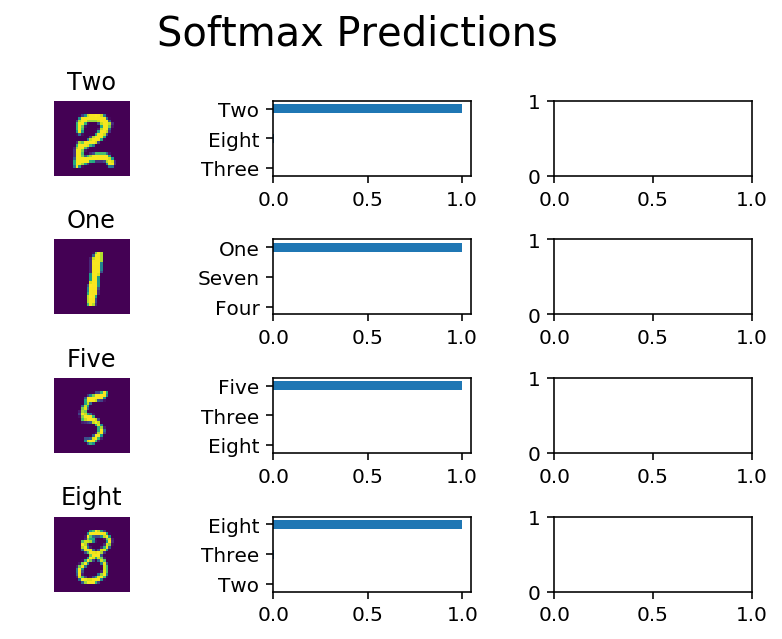

In [11]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import random

n_samples = 4
top_n_predictions = 3
save_model_path = './numbers_network_model'
meta_path = save_model_path + '.meta'
pb_model_name = 'mnist_model.pb'

def save_pb_model():
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        saver = tf.train.import_meta_graph(meta_path)
        
        saver.restore(sess,tf.train.latest_checkpoint('.'))

        frozen_graph_def = tf.graph_util.convert_variables_to_constants(
            sess,
            sess.graph_def,
            ['predictions'])

        with open(pb_model_name, 'wb') as f:
            f.write(frozen_graph_def.SerializeToString())
        sess.close()

def test_model():
    
    test_features = mnist.test.images.reshape((-1, 28, 28, 1))
    test_labels = mnist.test.labels
    
    loaded_graph = tf.Graph()

    with tf.Session(graph=loaded_graph) as sess:
        # Load model
        loader = tf.train.import_meta_graph(meta_path)
        loader.restore(sess, save_model_path)
        # Getting Tensors from loaded model
        loaded_x = loaded_graph.get_tensor_by_name('x:0')
        loaded_y = loaded_graph.get_tensor_by_name('y:0')
        loaded_logits = loaded_graph.get_tensor_by_name('logits:0')
        loaded_acc = loaded_graph.get_tensor_by_name('accuracy:0')
        
        test_batch_acc_total = 0
        test_batch_count = 0
        
        for i in range(mnist.test.num_examples//batch_size):
            batch = mnist.test.next_batch(batch_size)
            test_feature_batch = batch[0].reshape((-1, 28, 28, 1))
            test_label_batch = batch[1]
            test_batch_acc_total += sess.run(
                loaded_acc,
                feed_dict={loaded_x: test_feature_batch, loaded_y: test_label_batch })
            test_batch_count += 1

        print('Testing Accuracy: {}\n'.format(test_batch_acc_total/test_batch_count))

        random_test_features, random_test_labels = tuple(zip(*random.sample(list(zip(test_features, test_labels)), n_samples)))
        random_test_predictions = sess.run(
            tf.nn.top_k(tf.nn.softmax(loaded_logits), top_n_predictions),
            feed_dict={loaded_x: random_test_features, loaded_y: random_test_labels })
        display_image_predictions(random_test_features, random_test_labels, random_test_predictions, 10)
        sess.close()
        
save_pb_model()
test_model()
    